### Read SCREAM CESS data

Andrew Gettelman, Feb 2025

This code is designed to multiply write 2D 3hourly fields stored as ne1024


In [1]:
import healpix as hp
import numpy as np
import xarray as xr
import intake
import numcodecs
import zarr

import easygems.healpix as egh
import easygems.remap as egr

import matplotlib.pyplot as plt

import dask.array as da
import dask

import glob

### Basic Data parameters
Numbers correspond to speific files below

#### Hourly Native Resolution
	2. output.scream.Cess.hourly2DVars.INSTANT.nhours_x1.*
		- 49 times, hourly, raw 3km output (25M columns)
		- Precip, olr
#### 3 Hourly 0.25km 2D and 3D
    5. 3hourlyAVG_ne120.AVERAGE.nhours_x3.
        - Ne120 (25km), 3hrly, 221 levels
        - 2D and 3D variables
#### 2D land variables
    6. cess-oct2.elm.h1.
        - Daily land output on native land grid (swe, soil moisture)

In [2]:
### Path and data sets

#rfn='cess-control.ne1024pg2_ne1024pg2.F2010-SCREAMv1.cess-oct2/run/'
#fn='/global/cfs/cdirs/e3sm/gsharing/EAMxx/Cess/SCREAM3km/'+rfn

fn='/pscratch/sd/a/agett/scream/cess-copy/'

### Prefixes for 'Streams'

outpre='output.scream.Cess.'

fprefix=[]

fprefix.append('50hourly_QcQiNcNi.INSTANT.nhours_x50.')
#		- 128 levels, 1 time sample, raw 3km SCREAM grid (25M columns)
#		- nc, ni, qc, qi

fprefix.append('50hourly_QrNrQmBm.INSTANT.nhours_x50.')
#		- 128 levels, 1 time sample, raw 3km SCREAM grid (25M columns)
#		- bm, nr, qm, qr. (What is 'm'? Mixed? What is variable bm?)

fprefix.append('hourly2DVars.INSTANT.nhours_x1.')
#		- 49 times, hourly, raw 3km output (25M columns)
#		- Precip, olr

fprefix.append('6hourlyINST_ne30.INSTANT.nhours_x6.')
#		- Ne 30 (1deg), 4 times, 6 hourly, 221 levels
#		- 2D: IWP, LWP, RH, T_2m, WV_path, ps, 
#		- 3D: T_mid,horiz winds (dim2=U.v?), omega, O3, qc, qv, tke
#		- Static: landfrac, oceanfrac

fprefix.append('6hourlyAVG_ne30.AVERAGE.nhours_x6.')
#		- Ne 30 (1deg), 4 times, 6 hourly, 221 levels (don't need them)
#		- Needed variables (All 2D): LW flux at bot (up,down), LW flux up at top, SW dwn/up at top/bot (4)
#            horiz wind at bottom (U,V), ice_precip, liq_precip, ps, surf_evap, surf_mom (u,v), surf_T, 
#            surf sens_flux, upward LHF

fprefix.append('3hourlyAVG_ne120.AVERAGE.nhours_x3.')
#       - Ne 120 (25km), 24 times, 3 hourly, 221 levels
#       - Lots of variables could be used here (2D rad fluxes, Tmp, precip, ps) (3D qc,qi,qr,qv,z,omega, winds)
#       - most of what is needed is here!

fprefix.append('cess-control.ne1024pg2_ne1024pg2.F2010-SCREAMv1.cess-oct2.elm.h1.')
#       - Daily land files on native land grid (25M columns): H2OSNO, SOILWATER_10CM


In [3]:
st=5

if (st==6):
    fspec=fn+fprefix[st]+'*.nc'
else:
    fspec=fn+outpre+fprefix[st]+'*.nc'

file_list= glob.glob(fspec)

# Sort it by time
sorted_files = sorted(file_list)


In [4]:
#sorted_files

In [5]:
%%time
## Issues: 
# for ne30 data (s=3 and 4) one file has a day extra data (one file is 2 days apart, but has 3 days of data)
## So load it twice, and then append...

## Still issues with hourly data on native grid (s=2) [need to sort that out]. 

if (st == 5):
    del sorted_files[70]
    ds0=xr.open_mfdataset(sorted_files[:69])
    ds1=xr.open_mfdataset(sorted_files[69:])
    ds_scream=xr.concat([ds0,ds1.isel(time=slice(8,1536))],dim='time')
    del ds0,ds1
    
#    ds_scream=xr.open_mfdataset(sorted_files[124:127])   #testing 3 files in-situ
#    ds_scream=xr.open_mfdataset(sorted_files)      #3 files on scratch

if (st == 3) or (st==4):
    ds0=xr.open_mfdataset(sorted_files[:69])
    ds1=xr.open_mfdataset(sorted_files[69:])
    ds_scream=xr.concat([ds0,ds1.isel(time=slice(4,1529))],dim='time')
    del ds0,ds1

if (st < 2) or (st==6):
    ds_scream=xr.open_mfdataset(sorted_files)


CPU times: user 3.97 s, sys: 911 ms, total: 4.88 s
Wall time: 6.58 s


### To remove error about 'large chunks'

In [6]:
dask.config.set(**{'array.slicing.split_large_chunks': True})

### Vertical Information

In [7]:
### Vertical Levels for s=3,5 (221)
levfile='/global/cfs/cdirs/e3sm/gsharing/EAMxx/Cess/SCREAM3km/grids/vrt_remapping_p_levs_20230926.nc'
slev=xr.open_dataset(levfile)

In [8]:
### Vertical levels to interpolate to.
tr = np.arange(100,900,100)
lt = np.arange(850,1025,25)
ua = np.arange(10,90,20)
levels = sorted({1,5,20,150,250,750}.union(tr,lt,ua))
levels = [int(x) for x in levels]

In [9]:
ds_scream=ds_scream.assign_coords({"lev":slev.p_levs.values/100.})

In [10]:
ds_scream=ds_scream.interp(lev=levels)

In [11]:
ds_scream=ds_scream.rename_dims({"lev":"level"})

In [12]:
# Do this once for each stream to get a list of things in the file
#list(ds_scream.keys())

### Process data
Focus on 2D fields, will loop over varn2D here

In [13]:
if(st==3):
    varn2D=['IceWaterPath','LiqWaterPath','VapWaterPath','T_2m','landfrac','ocnfrac',
            'qv_2m','surf_radiative_T','ps']
    varn3D=['T_mid','omega','RelativeHumidity','qc','qi','qr','qv','tke']
    varn4D=['horiz_winds']

if(st==5):
    varn2D=['LW_clrsky_flux_dn_at_model_bot','LW_clrsky_flux_up_at_model_top', 'LW_flux_dn_at_model_bot',
            'LW_flux_up_at_model_bot','LW_flux_up_at_model_top','LongwaveCloudForcing',
            'SW_clrsky_flux_dn_at_model_bot','SW_clrsky_flux_up_at_model_bot','SW_clrsky_flux_up_at_model_top',
            'SW_flux_dn_at_model_bot','SW_flux_dn_at_model_top','SW_flux_up_at_model_bot',
            'SW_flux_up_at_model_top','ShortwaveCloudForcing',
            'T_2m','precip_ice_surf_mass_flux','precip_liq_surf_mass_flux','ps',
            'sfc_flux_lw_dn','sfc_flux_sw_net','surf_evap','surf_radiative_T',
            'surf_sens_flux','surface_upward_latent_heat_flux','qv_at_model_bot',
            'uas','vas','tauu','tauv']
# Mapping names
    varn2Dout=['rldscs','rlutcs', 'rlds',
            'rlus','rlut','lwcre',
            'rsdscs','rsuscs','rsutcs',
            'rsds','rsdt','rsus',
            'rsut','swcre',
            'tas','prs','pr','ps',
            'sfc_flux_lw_dn','sfc_flux_sw_net','surf_evap','ts',
            'hfssd','hflsd','huss',
            'uas','vas','tauu','tauv']
    
#    varn2Dvec=['horiz_winds_at_model_bot','surf_mom_flux']
#    varn2DvecOut=['uas','vas','tauu','tauv']
    
    varn3D=['T_mid','omega','qall','qv','z_mid','ua','va']

    varn3Dout=['ta','omega','qall','hus','zg','ua','va']  #qall=qc+qi+qr
    
#    varn3Dvec=['horiz_winds']
#   varn3DvecOut=['ua','va']
    
if(st==6):
    varn2D=['H2OSNO','SOILWATER_10CM']
    varn2Dout=['swe','mrso']

### Unwrap vector fields and Combine hydrometeors

In [14]:
# 10m wind
ds_scream['ua']=ds_scream.horiz_winds.isel(dim2=0)
ds_scream['va']=ds_scream.horiz_winds.isel(dim2=1)
# total condensed water
ds_scream['qall']=ds_scream.qc+ds_scream.qi+ds_scream.qv

### Reduce data to needed variables

In [15]:
#Shrink Array to what is needed

# Map and rename variables
rename_dict = dict(zip(varn3D, varn3Dout))
ds_scream=ds_scream.rename(rename_dict)

### Save off lat and lon

slon=ds_scream.lon.isel(time=0)
slat=ds_scream.lat.isel(time=0)

### Keep only the needed variables

ds_scream=ds_scream[varn3Dout]

### or just keep one variable, all levels?

In [16]:
ds_scream

<xarray.Dataset> Size: 766GB
Dimensions:  (time: 3168, ncol: 345600, level: 25)
Coordinates:
  * time     (time) object 25kB 2019-08-01 03:00:00 ... 2020-09-01 00:00:00
  * lev      (level) int64 200B 1 5 10 20 30 50 70 ... 875 900 925 950 975 1000
Dimensions without coordinates: ncol, level
Data variables:
    ta       (time, ncol, level) float32 109GB dask.array<chunksize=(16, 345600, 25), meta=np.ndarray>
    omega    (time, ncol, level) float32 109GB dask.array<chunksize=(16, 345600, 25), meta=np.ndarray>
    qall     (time, ncol, level) float32 109GB dask.array<chunksize=(16, 345600, 25), meta=np.ndarray>
    hus      (time, ncol, level) float32 109GB dask.array<chunksize=(16, 345600, 25), meta=np.ndarray>
    zg       (time, ncol, level) float32 109GB dask.array<chunksize=(16, 345600, 25), meta=np.ndarray>
    ua       (time, ncol, level) float32 109GB dask.array<chunksize=(16, 345600, 25), meta=np.ndarray>
    va       (time, ncol, level) float32 109GB dask.array<chunksize=(16, 345600, 25), meta=np.ndarray>
Attributes: (12/22)
    institutions:                 LLNL (Lawrence Livermore National Laborator...
    case_t0:                      2019-08-01-00000
    run_t0:                       2019-08-01-00000
    averaging_type:               AVERAGE
    averaging_frequency_units:    nhours
    averaging_frequency:          3
    ...                           ...
    contact:                      e3sm-data-support@llnl.gov
    institution_id:               E3SM-Projet
    realm:                        atmos
    history:                      created on Sun Oct  8 17:33:21 2023
    Conventions:                  CF-1.8
    product:                      model-output

### Helper Functions for Zarr Encoding

In [17]:
# Single Precision for Floats

def get_dtype(da):
    if np.issubdtype(da.dtype, np.floating):
        return "float32"
    else:
        return da.dtype
    
    
# Chunking (note, 'cell' has to match name of column dimension in input)

def get_chunks(dimensions):
    if "level" in dimensions:
        chunks = {
            "time": 24,
            "cell": 4**6,
            "level": 1,
        }
    else:
        chunks = {
            "time": 24,
            "cell": 4**6,
        }

    return tuple((chunks[d] for d in dimensions))

# Compression

def get_compressor():
    return numcodecs.Blosc("zstd", shuffle=2)

In [18]:
#Loop over all variables and create encoding directory...

def get_encoding(dataset):
    return {
        var: {
            "compressor": get_compressor(),
            "dtype": get_dtype(dataset[var]),
            "chunks": get_chunks(dataset[var].dims),
        }
        for var in dataset.variables
        if var not in dataset.dims
    }

### Create a HealPix Grid or read Pre-calculated weights

In [19]:
#%%time
#
#s='6'
#order = zoom = int(s)
#nside = hp.order2nside(order)
#npix = hp.nside2npix(nside)
#
#write = True
#
#if write:
#
#    hp_lon, hp_lat = hp.pix2ang(nside=nside, ipix=np.arange(npix), lonlat=True, nest=True)
#    hp_lon = (hp_lon + 180) % 360 - 180  # [-180, 180)
#    hp_lon += 360 / (4 * nside) / 4  # shift quarter-width
#
#    slon=(slon + 180) % 360 - 180  # [-180, 180)
#
#    eweights = egr.compute_weights_delaunay((slon, slat), (hp_lon, hp_lat))
#
## You can also save the calculated weights for future use
#    eweights.to_netcdf("scream_ne30_healpix_weights"+s+".nc")

#else: 
#    eweights=xr.open_dataset("/global/u1/a/agett/python/hackathon/scream_ne30_healpix_weights"+s+".nc") 


### Version 2 designed to work with ne30 lower resolution grid
From Lukas Kluft

The idea is to create an extended version of the grid by padding it with itself, but shifted to the east and west. 
Then the triangulation weights can be computed without any gaps. 
In a final step, the extended index values can be mapped back to the original source index. 
The resulting weights can then be used as before. 


In [20]:
%%time
#Version 2

s='8'
order = zoom = int(s)
nside = hp.order2nside(order)
npix = hp.nside2npix(nside)

write = False

if write:

    hp_lon, hp_lat = hp.pix2ang(nside=nside, ipix=np.arange(npix), lonlat=True, nest=True)
    hp_lon = (hp_lon + 180) % 360 - 180  # [-180, 180)
    hp_lon += 360 / (4 * nside) / 4  # shift quarter-width


#    slon=ds_scream.lon.isel(time=0)
#    slat=ds_scream.lat.isel(time=0)
    
# Periodically extend longitude to the east and west
    lon_periodic = np.hstack((slon - 360, slon, slon + 360))
    lat_periodic = np.hstack((slat, slat, slat))

# Compute weights
    eweights = egr.compute_weights_delaunay(
        points=(lon_periodic, lat_periodic),
        xi=(hp_lon, hp_lat)
    )

# Remap the source indices back to their valid range
    eweights = eweights.assign(src_idx=eweights.src_idx % slat.size)

# Save the calculated weights for future use
    eweights.to_netcdf("scream_ne120_healpix_weights"+s+".nc")

else: 
    eweights=xr.open_dataset("/global/u1/a/agett/python/hackathon/scream_ne120_healpix_weights"+s+".nc") 


CPU times: user 8.34 ms, sys: 1.16 ms, total: 9.5 ms
Wall time: 49.2 ms


In [21]:
plt.rcParams['figure.figsize'] = [12, 8]

In [22]:
### Rewrite from Jill Zhang
def custom_indexing(ds_var, src_idx, weights, valid):
    # Perform the advanced indexing in a NumPy context
    return np.where(
        valid,
        (ds_var[src_idx] * weights).sum(axis=-1),
        np.nan
    )

In [ ]:
### Plot

In [23]:
# select variable
v=6

CPU times: user 6min 36s, sys: 26.3 s, total: 7min 3s
Wall time: 50.3 s


<Figure size 1200x800 with 0 Axes>

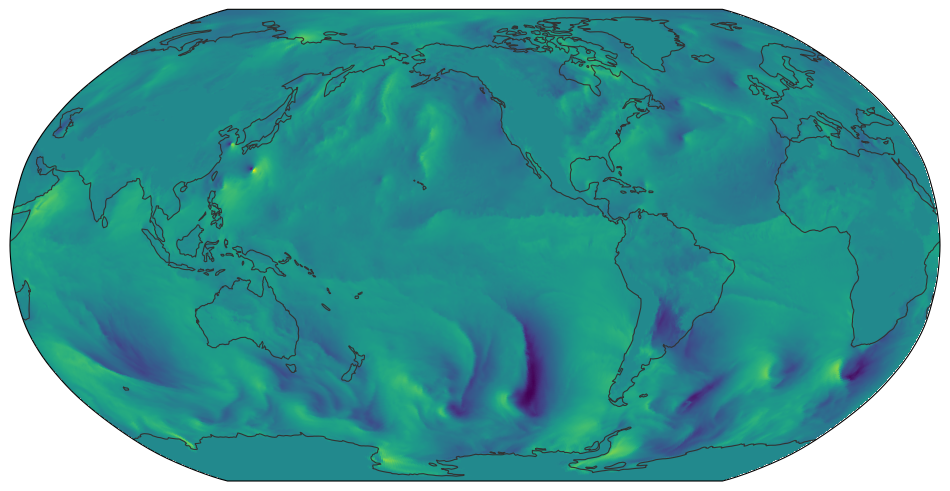

In [24]:
%%time

### Fast way from Jill Zhang

valid = eweights["valid"]
src_idx = eweights["src_idx"]
weights = eweights["weights"]
 
# Use map_blocks to apply the function on Dask chunks
rewrite = da.map_blocks(
    custom_indexing,
    ds_scream[varn3Dout[v]].isel(time=50,level=22), src_idx, weights, valid,
    dtype=float  # Specify output dtype
)
egh.healpix_show(rewrite.compute())

### Remap The full data set
Use xarray’s apply_ufunc() function to lift the function onto a full dataset

In [25]:
%%time
### SCREAM version

# if the dataset contains coordinates, then remove them 
#if 'lat' in ds_scream.variables:
#    ds_scream_sm=ds_scream.drop_vars(['lat','lon'])
    
scream_remap = xr.apply_ufunc(
    egr.apply_weights,
    ds_scream[varn3Dout[v]].to_dataset(name=varn3Dout[v]),
    kwargs=eweights,
    keep_attrs=True,
    input_core_dims=[["ncol"]],
    output_core_dims=[["cell"]],
    output_dtypes=["f4"],
    vectorize=True,
    dask="parallelized",
    dask_gufunc_kwargs={
        "output_sizes": {"cell": npix},
    },
)
scream_remap

CPU times: user 21.5 ms, sys: 100 μs, total: 21.6 ms
Wall time: 19.4 ms


<xarray.Dataset> Size: 249GB
Dimensions:  (time: 3168, level: 25, cell: 786432)
Coordinates:
  * time     (time) object 25kB 2019-08-01 03:00:00 ... 2020-09-01 00:00:00
  * lev      (level) int64 200B 1 5 10 20 30 50 70 ... 875 900 925 950 975 1000
Dimensions without coordinates: level, cell
Data variables:
    va       (time, level, cell) float32 249GB dask.array<chunksize=(16, 25, 786432), meta=np.ndarray>

In [ ]:
%%time
### Plot it: this is relatively fast (12sec)
#egh.healpix_show(ds_remap.ts.sel(time="1990-12-31").mean("time"))

#egh.healpix_show(scream_remap[varn3Dout[1]].isel(time=10,level=5))

### Store coordinate Reference System

In [26]:
scream_remap["crs"] = xr.DataArray(
    name="crs",
    data=[],
    dims="crs",
    attrs={
        "grid_mapping_name": "healpix",
        "healpix_nside": 2**zoom,
        "healpix_order": "nest",
    },
)

In [27]:
#Select one variable but keep it a dataset
#scream_remap[varn2Dout[v]].to_dataset(name=varn2Dout[v])

### Write to Zarr 
Here is where I can loop by variable...(or might be able to just let it go?)

In [28]:
%%time

# 1 year of 2D level 8 (25km) @3 hrly = 12GB, 2m38s

opth='/pscratch/sd/a/agett/hackathon_zarr_singles/'

##selected variables
##for v in range(3):
#ofn=opth+"scream3D_ne120_"+varn3Dout[v]+"_hp"+s+"_v6.zarr"
#store = zarr.storage.DirectoryStore(ofn, dimension_separator="/")
#scream_remap[varn3Dout[v]].to_dataset(name=varn3Dout[v])\
#    .chunk({"time": 12, "cell": -1, "level": 5})\
#    .to_zarr(store, encoding=get_encoding(scream_remap[varn3Dout[v]].to_dataset(name=varn3Dout[v])))
    

ofn=opth+"scream3D_ne120_"+varn3Dout[v]+"_hp"+s+"_v6.zarr"
store = zarr.storage.DirectoryStore(ofn, dimension_separator="/")
scream_remap.chunk({"time": 24, "cell": 4**6, "level": 1}).to_zarr(store, encoding=get_encoding(scream_remap))

CPU times: user 14h 37min 56s, sys: 1h 34min 26s, total: 16h 12min 23s
Wall time: 44min 21s


### Test Read Back

In [29]:
#s='8'
opth='/pscratch/sd/a/agett/hackathon_zarr_singles/'
ofn=opth+"scream3D_ne120_"+varn3Dout[v]+"_hp"+s+"_v6.zarr"

In [30]:
del scream_remap

/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/core/indexing.py:1620: PerformanceWarning: Slicing with an out-of-order index is generating 81 times more chunks
  return self.array[key]


CPU times: user 1.82 s, sys: 154 ms, total: 1.97 s
Wall time: 1.82 s


<Figure size 1200x800 with 0 Axes>

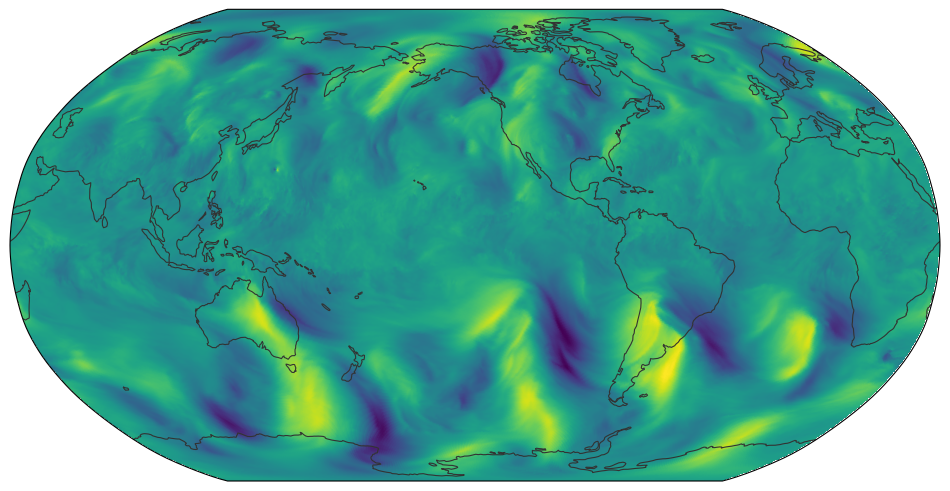

In [31]:
%%time

ds2=xr.open_dataset(ofn,chunks={"time":24,"cell":  4**6,"level":1}) #This makes is slow, but needed for hp7,6
#ds2=xr.open_dataset(ofn) # This is better, but should perhaps not be. Does not work for hp7
egh.healpix_show(ds2[varn3Dout[v]].isel(time=20,level=10))

### Write other resolutions

In [32]:
#del scream_remap

In [33]:
import gc
dask.config.set(**{'array.slicing.split_large_chunks': False})  # reset this to be able to run other levels....

In [34]:
%%time
# Now Loop (max memory is 32GB test for zoom =7 Not using dask right or the assigment should be different...)
dn=ds2
#del ds2
for x in range(7,5,-1):
    s=str(x)
    fn="scream3D_ne120_"+varn3Dout[v]+"_hp"+s+"_v6.zarr"
    print(fn)
    dx=dn.coarsen(cell=4).mean()
    dx['crs'].attrs['healpix_nside'] = 2**int(s)   # Update HEALPix level metadata
    store = zarr.storage.DirectoryStore(opth+fn, dimension_separator="/")
    dx.chunk({"time": 24, "cell": 4**6, "level": 1}).to_zarr(store, encoding=get_encoding(dx))
    dn=dx
    del dx,store
    gc.collect()

del dn

scream3D_ne120_va_hp7_v6.zarr
scream3D_ne120_va_hp6_v6.zarr
CPU times: user 1h 22min 18s, sys: 25min 33s, total: 1h 47min 52s
Wall time: 37min 22s


In [ ]:
### Read in for lower resolutions differently

In [35]:
del ds2

s='6'
ofn=opth+"scream3D_ne120_"+varn3Dout[v]+"_hp"+s+"_v6.zarr"
ds2=xr.open_dataset(ofn) # This is better, but data intensive. use on level 5 or lower....
ds2

/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


<xarray.Dataset> Size: 16GB
Dimensions:  (crs: 0, level: 25, time: 3168, cell: 49152)
Coordinates:
  * crs      (crs) float64 0B 
    lev      (level) int64 200B ...
  * time     (time) object 25kB 2019-08-01 03:00:00 ... 2020-09-01 00:00:00
Dimensions without coordinates: level, cell
Data variables:
    va       (time, level, cell) float32 16GB ...

In [36]:
%%time
# Now Loop (max memory is 32GB test for zoom =7 Not using dask right or the assigment should be different...)
dn=ds2
#del ds2
for x in range(5,-1,-1):
    s=str(x)
    fn="scream3D_ne120_"+varn3Dout[v]+"_hp"+s+"_v6.zarr"
    print(fn)
    dx=dn.coarsen(cell=4).mean()
    dx['crs'].attrs['healpix_nside'] = 2**int(s)   # Update HEALPix level metadata
    store = zarr.storage.DirectoryStore(opth+fn, dimension_separator="/")
    dx.chunk({"time": 24, "cell": 4**6, "level": 1}).to_zarr(store, encoding=get_encoding(dx))
    dn=dx
    del dx,store
    gc.collect()

del dn

scream3D_ne120_va_hp5_v6.zarr
scream3D_ne120_va_hp4_v6.zarr
scream3D_ne120_va_hp3_v6.zarr
scream3D_ne120_va_hp2_v6.zarr
scream3D_ne120_va_hp1_v6.zarr
scream3D_ne120_va_hp0_v6.zarr
CPU times: user 2min 23s, sys: 1min 6s, total: 3min 29s
Wall time: 1min 59s


### Plot Any Resolution

In [ ]:
%%time
s='8'
fn=opth+"scream3D_ne120_"+varn3D[v]+"_hp"+s+"_v6.zarr"

#fn=opth+'test_dask_70GB_1mo_hp10.zarr'

ds=xr.open_dataset(fn)
egh.healpix_show(ds[varn2D[v]].isel(time=1))
plt.title('HealPix Level '+s)

/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


<Figure size 600x400 with 0 Axes>

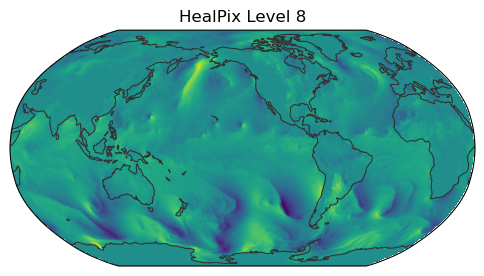

/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


<Figure size 600x400 with 0 Axes>

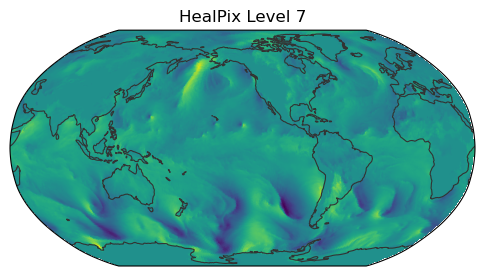

/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


<Figure size 600x400 with 0 Axes>

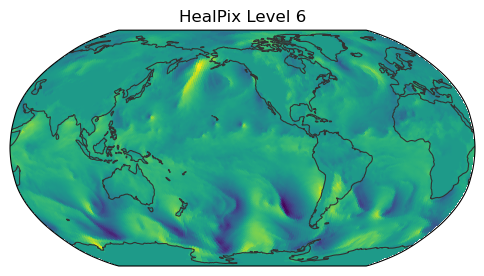

/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


<Figure size 600x400 with 0 Axes>

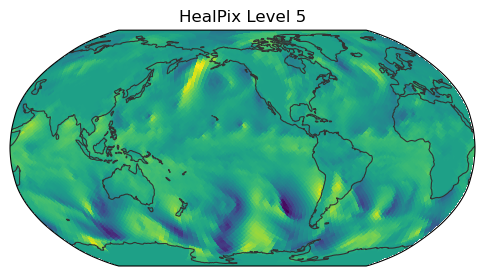

/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


<Figure size 600x400 with 0 Axes>

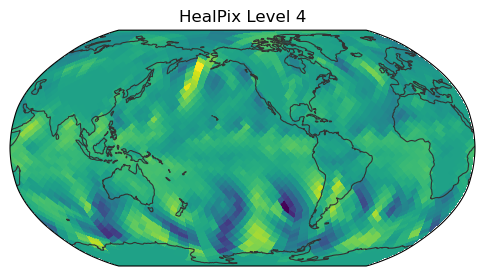

/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


<Figure size 600x400 with 0 Axes>

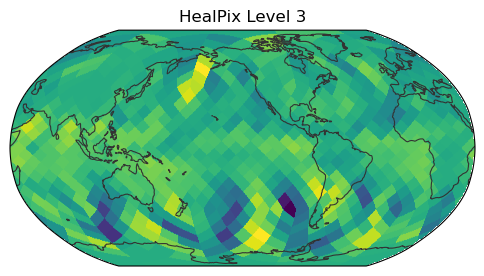

/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


<Figure size 600x400 with 0 Axes>

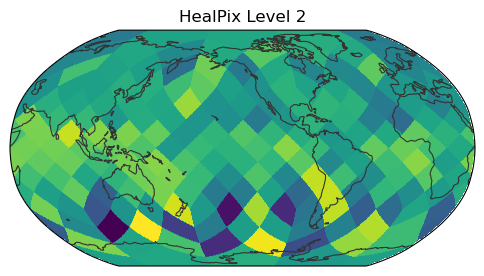

/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


<Figure size 600x400 with 0 Axes>

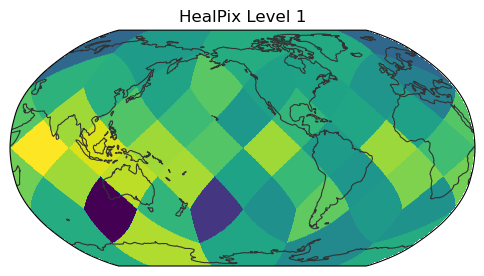

/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


<Figure size 600x400 with 0 Axes>

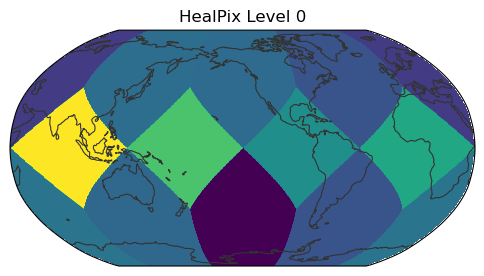

CPU times: user 1.09 s, sys: 146 ms, total: 1.23 s
Wall time: 2.01 s


In [38]:
%%time
plt.rcParams['figure.figsize'] = [6, 4]

#v=0
for x in range(8,-1,-1):
    s=str(x)
    fn=opth+"scream3D_ne120_"+varn3Dout[v]+"_hp"+s+"_v6.zarr"
    ds=xr.open_dataset(fn)
    egh.healpix_show(ds[varn3Dout[v]].isel(time=10,level=22))
    plt.title('HealPix Level '+s)
    plt.show()
    del ds